In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from tqdm import tqdm_notebook as tqdm
import datetime
from meteocalc import feels_like, Temp
from sklearn import metrics
import seaborn as sns
import gc
import os

In [3]:

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
train_df = pd.read_csv('../input/train.csv')
building_df = pd.read_csv('../input/building_metadata.csv')
weather_df = pd.read_csv('../input/weather_train.csv')

In [6]:
# eliminate bad rows
bad_rows = pd.read_csv('rows_to_drop.csv')
train_df.drop(bad_rows.loc[:, '0'], inplace = True)
train_df.reset_index(drop = True, inplace = True)

In [7]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    
    def get_meteorological_features(data):
        def calculate_rh(df):
            df['relative_humidity'] = 100 * (np.exp((17.625 * df['dew_temperature']) / (243.04 + df['dew_temperature'])) / np.exp((17.625 * df['air_temperature'])/(243.04 + df['air_temperature'])))
        def calculate_fl(df):
            flike_final = []
            flike = []
            # calculate Feels Like temperature
            for i in range(len(df)):
                at = df['air_temperature'][i]
                rh = df['relative_humidity'][i]
                ws = df['wind_speed'][i]
                flike.append(feels_like(Temp(at, unit = 'C'), rh, ws))
            for i in range(len(flike)):
                flike_final.append(flike[i].f)
            df['feels_like'] = flike_final
            del flike_final, flike, at, rh, ws
        calculate_rh(data)
        calculate_fl(data)
        return data

    weather_df = get_meteorological_features(weather_df)
    return weather_df

In [8]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
    df['month'] = df['timestamp'].dt.month
    df['month'].replace((1, 2, 3, 4), 1, inplace = True)
    df['month'].replace((5, 6, 7, 8), 2, inplace = True)
    df['month'].replace((9, 10, 11, 12), 3, inplace = True)
  
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [9]:
# weather manipulation
weather_df = fill_weather_dataset(weather_df)

# memory reduction
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

# merge data
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

/home/tunguz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


Memory usage of dataframe is 586.85 MB
Memory usage after optimization is: 165.43 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 11.80 MB
Memory usage after optimization is: 3.19 MB
Decreased by 72.9%


0

In [10]:
# feature engineering
train_df = features_engineering(train_df)

# transform target variable
train_df['meter_reading'] = np.log1p(train_df["meter_reading"])

In [11]:
# declare target, categorical and numeric columns
target = 'meter_reading'
categorical = ['building_id', 'site_id', 'primary_use', 'meter','dayofweek']
numeric_cols = [col for col in train_df.columns if col not in categorical + [target, 'timestamp', 'month']]
features = categorical + numeric_cols

In [13]:
# read test
test_df = pd.read_csv('../input/test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

# merge with building info
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

# fill test weather data
weather_df = pd.read_csv('../input/weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

# merge weather data
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

# feature engineering
test_df = features_engineering(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


/home/tunguz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


Memory usage of dataframe is 23.53 MB
Memory usage after optimization is: 11.18 MB
Decreased by 52.5%


In [14]:
test_df.shape

(41697600, 19)

In [15]:
train_df.shape

(19229841, 20)

In [16]:
test_df = test_df[features]
train_df = train_df[features]

In [17]:
train_df.shape

(19229841, 18)

In [18]:
test_df.shape

(41697600, 18)

In [19]:
train_df['target'] = 0
test_df['target'] = 1

/home/tunguz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
train_test = pd.concat([train_df, test_df], axis =0)



#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp.fit(train_test[columns])
#train_test[columns] = imp.transform(train_test[columns])
target = train_test['target'].values


del train_df, test_df
gc.collect()

2789

In [23]:
train, test = model_selection.train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)
del train_test
gc.collect()

55

In [24]:
train_y = train['target'].values
test_y = test['target'].values
del train['target'], test['target']
gc.collect()

0

In [25]:
train = lgb.Dataset(train, label=train_y)
test = lgb.Dataset(test, label=test_y)
gc.collect()

0

In [26]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 2,
         'learning_rate': 0.2,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 44,
         "metric": 'auc',
         "verbosity": -1}

In [27]:
num_round = 50
clf = lgb.train(param, train, num_round, valid_sets = [train, test], verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.965243	valid_1's auc: 0.965261
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.965243	valid_1's auc: 0.965261


Well, that's really interesting. AUC of 0.96 is huge. The final LB could go through a significant shakeup. 

Let's take a look at the feature importances:

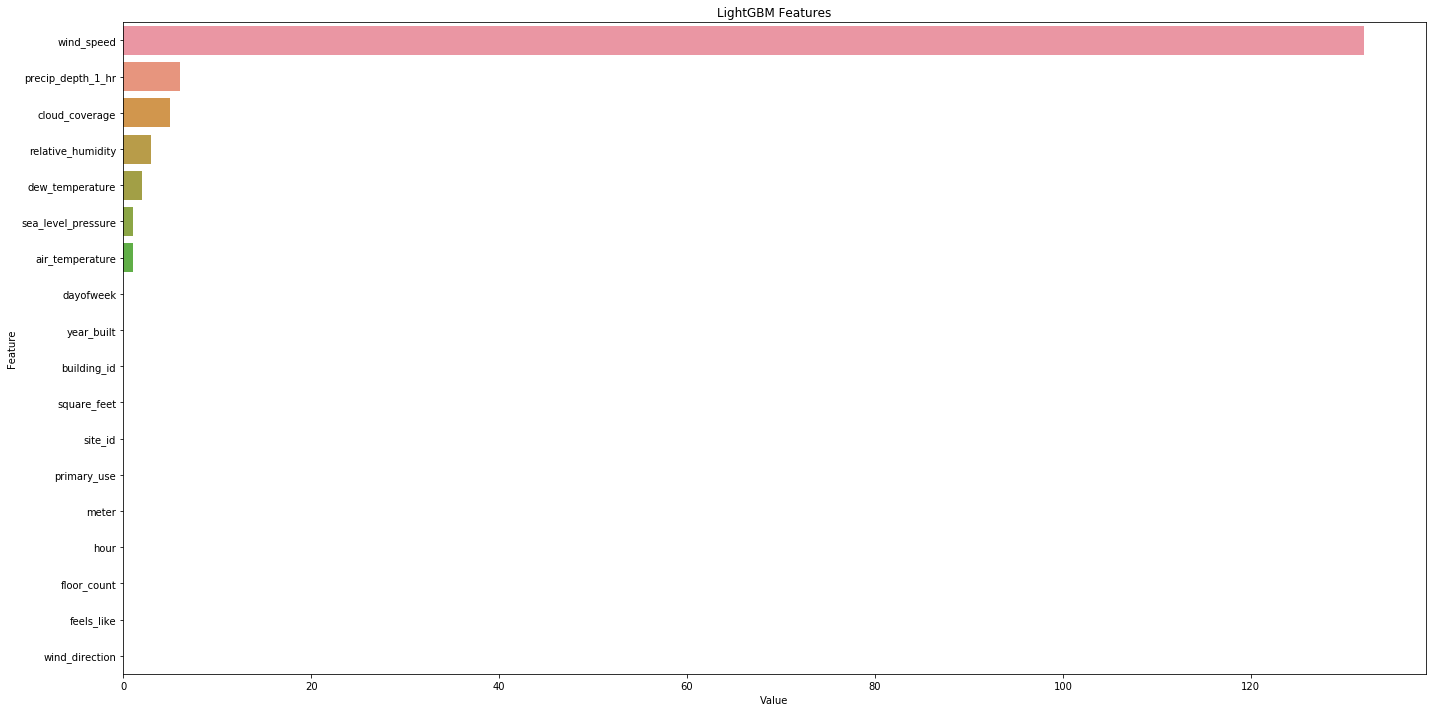

<Figure size 432x288 with 0 Axes>

In [29]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Wow, check out that wind speed! Seems like the main difference between train and test.